Import das bibliotecas necessárias para execução e criação dos modelos

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 1

In [3]:

#Load dataset
def load_dataset(path=r'dataset_final_semanal.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
#preparing the data for the LSTM
def prepare_data(df):
        df_aux = df.copy()
        df_aux["Date"] = pd.to_datetime(df_aux["Date"])
        df_aux = df_aux.set_index('Date')
        df_aux = df_aux.drop(columns=["Unnamed: 0"])
        #reindex para por variável objetivo como primeira
        df_aux = df_aux.reindex(columns=['Pneumonia Deaths','obitos', 'confirmados_novos', 'recuperados', 'Temperature',
                'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio',
                'new_cases_per_million_Austria', 'new_deaths_per_million_Austria',
                'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium',
                'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium',
                'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada',
                'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada',
                'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia',
                'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark',
                'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France',
                'new_cases_per_million_Georgia', 'new_cases_per_million_Germany',
                'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany',
                'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary',
                'positive_rate_India', 'new_cases_per_million_Ireland',
                'new_deaths_per_million_Ireland', 'icu_patients_per_million_Ireland',
                'hosp_patients_per_million_Ireland', 'new_tests_per_thousand_Ireland',
                'positive_rate_Ireland', 'new_tests_per_thousand_Italy',
                'new_cases_per_million_Japan', 'new_deaths_per_million_Japan',
                'new_cases_per_million_Latvia', 'new_deaths_per_million_Latvia',
                'hosp_patients_per_million_Latvia', 'new_tests_per_thousand_Latvia',
                'new_cases_per_million_Lithuania', 'new_tests_per_thousand_Lithuania',
                'icu_patients_per_million_Luxembourg', 'new_deaths_per_million_Malta',
                'new_tests_per_thousand_Malta', 'positive_rate_Malta',
                'new_cases_per_million_Monaco', 'new_cases_per_million_Montenegro',
                'positive_rate_Mozambique', 'new_deaths_per_million_Poland',
                'positive_rate_Romania', 'new_cases_per_million_Russia',
                'new_deaths_per_million_Russia', 'new_deaths_per_million_Serbia',
                'positive_rate_Serbia', 'new_cases_per_million_Slovakia',
                'new_tests_per_thousand_Slovakia', 'new_cases_per_million_Slovenia',
                'new_deaths_per_million_Slovenia', 'icu_patients_per_million_Slovenia',
                'new_tests_per_thousand_Slovenia', 'new_deaths_per_million_Switzerland',
                'new_cases_per_million_Turkey', 'positive_rate_Ukraine',
                'new_deaths_per_million_United Arab Emirates',
                'tests_per_case_United Arab Emirates',
                'new_cases_per_million_United Kingdom',
                'new_deaths_per_million_United Kingdom',
                'icu_patients_per_million_United Kingdom',
                'hosp_patients_per_million_United Kingdom',
                'positive_rate_United Kingdom', 'new_cases_per_million_United States',
                'new_deaths_per_million_United States', 'COVID-19 Deaths',
                'Influenza Deaths', 'flights', 'commercial_flights',
                'People Screened at Airports', 'US International Commercial Flights',
                'Nr People not staying home', 'Nr of trips'])
        return df_aux

In [6]:
# def data_normalization(df, norm_range=(-1, 1)):
#   #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
#   scaler = MinMaxScaler(feature_range=norm_range)
#   df = scaler.fit_transform(df)
#   return scaler

In [7]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'Pneumonia Deaths']
    print(colunas)
    for col in colunas:
      df[[col]] = scaler.fit_transform(df[[col]])
    df[['Pneumonia Deaths']] = scaler.fit_transform(df[['Pneumonia Deaths']])
    
    return scaler

In [8]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [9]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [10]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
      # y.append(data[input_index:label_index, 0:n_variate])

  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [11]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [12]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  # model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'Covid_model.png', show_shapes=True)
  return model

In [13]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size,learning_rate):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [14]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)


In [15]:
scaler = data_normalization(df) #scaling data to [-1, 1]

['obitos', 'confirmados_novos', 'recuperados', 'Temperature', 'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio', 'new_cases_per_million_Austria', 'new_deaths_per_million_Austria', 'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium', 'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium', 'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada', 'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada', 'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia', 'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark', 'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France', 'new_cases_per_million_Georgia', 'new_cases_per_million_Germany', 'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany', 'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary', 'positive_rate_India', 'new_cases_per_million_Ireland', 'new_deaths_per_million_Ireland', 'icu_patients_per_million_Irel

In [16]:
df

,Pneumonia Deaths,obitos,confirmados_novos,recuperados,Temperature,Visibility,total_testes,testes_pcr,testes_antigenio,new_cases_per_million_Austria,new_deaths_per_million_Austria,new_cases_per_million_Belgium,new_deaths_per_million_Belgium,icu_patients_per_million_Belgium,hosp_patients_per_million_Belgium,new_deaths_per_million_Bulgaria,new_cases_per_million_Canada,new_deaths_per_million_Canada,icu_patients_per_million_Canada,new_cases_per_million_Cyprus,new_deaths_per_million_Czechia,hosp_patients_per_million_Czechia,new_cases_per_million_Denmark,new_tests_per_thousand_Estonia,icu_patients_per_million_France,new_cases_per_million_Georgia,new_cases_per_million_Germany,new_deaths_per_million_Germany,icu_patients_per_million_Germany,new_deaths_per_million_Hungary,hosp_patients_per_million_Hungary,positive_rate_India,new_cases_per_million_Ireland,new_deaths_per_million_Ireland,icu_patients_per_million_Ireland,hosp_patients_per_million_Ireland,new_tests_per_thousand_Ireland,positive_rate_Ireland,new_tests_per_thousand_Italy,new_cases_per_million_Japan,...,new_tests_per_thousand_Lithuania,icu_patients_per_million_Luxembourg,new_deaths_per_million_Malta,new_tests_per_thousand_Malta,positive_rate_Malta,new_cases_per_million_Monaco,new_cases_per_million_Montenegro,positive_rate_Mozambique,new_deaths_per_million_Poland,positive_rate_Romania,new_cases_per_million_Russia,new_deaths_per_million_Russia,new_deaths_per_million_Serbia,positive_rate_Serbia,new_cases_per_million_Slovakia,new_tests_per_thousand_Slovakia,new_cases_per_million_Slovenia,new_deaths_per_million_Slovenia,icu_patients_per_million_Slovenia,new_tests_per_thousand_Slovenia,new_deaths_per_million_Switzerland,new_cases_per_million_Turkey,positive_rate_Ukraine,new_deaths_per_million_United Arab Emirates,tests_per_case_United Arab Emirates,new_cases_per_million_United Kingdom,new_deaths_per_million_United Kingdom,icu_patients_per_million_United Kingdom,hosp_patients_per_million_United Kingdom,positive_rate_United Kingdom,new_cases_per_million_United States,new_deaths_per_million_United States,COVID-19 Deaths,Influenza Deaths,flights,commercial_flights,People Screened at Airports,US International Commercial Flights,Nr People not staying home,Nr of trips
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,-0.999375,-1.000000,-1.000000,-1.000000,-0.274766,0.410117,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.912926,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.995806,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.907514,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.891741,-1.000000,-1.000000,-1.000000,0.872598,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.974134,1.000000,1.000000,1.000000,0.977380,0.613777
2020-03-08,-1.000000,-1.000000,-0.999305,-1.000000,-0.235083,0.657588,-0.998023,-0.997653,-1.000000,-0.996929,-1.000000,-0.996716,-0.912926,-1.000000,-1.000000,-1.000000,-0.999125,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.997652,-0.992788,-0.995772,-0.999535,-0.990282,-1.000000,-1.000000,-1.000000,-0.999476,-1.000000,-0.999256,-0.995806,-1.000000,-0.994868,-1.000000,-1.000000,-0.985604,-0.992907,...,-1.000000,-1.000000,-1.000000,-0.980634,-1.000000,-0.919075,-1.000000,-1.000000,-1.000000,-1.000000,-0.999849,-1.000000,-1.000000,-1.000000,-0.999711,-0.999550,-0.997746,-1.000000,-1.000000,-0.960587,-0.886307,-1.000000,-1.000000,-1.000000,1.000000,-0.998428,-0.999532,-1.000000,-1.000000,-1.000000,-0.999453,-0.998414,-0.998359,0.971564,1.000000,0.961335,0.723045,0.980974,1.000000,0.662269
2020-03-15,-0.909958,-1.000000,-0.995023,-0.999950,-0.0941

In [17]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    # se for necessário prever mais do que 1 semana
    # list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
    # print('list_yhat:')
    # print(list_yhat)
    # #preparar novo input para fazer previsão para a semana seguinte
    # inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
    # print('forecasts:')
    # print(forecasts)
  return forecasts



In [18]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(20,8))
  plt.plot(range(len(data)), data['Pneumonia Deaths'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Pneumonia Deaths in USA')
  plt.ylabel('Number of Deaths')
  plt.xlabel('Weeks')
  plt.legend()
  plt.show()

# Tunning

In [19]:
tunning_dict = {               
                1: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
# record da history de cada modelo
record = {}

Epoch 1/25
15/15 [==============================] - 4s 64ms/step - loss: 0.5525 - mae: 0.5515 - rmse: 0.5525 - val_loss: 0.8607 - val_mae: 0.8599 - val_rmse: 0.8607
Epoch 2/25
15/15 [==============================] - 0s 4ms/step - loss: 0.5112 - mae: 0.5088 - rmse: 0.5112 - val_loss: 0.7396 - val_mae: 0.7362 - val_rmse: 0.7396
Epoch 3/25
15/15 [==============================] - 0s 4ms/step - loss: 0.4130 - mae: 0.4055 - rmse: 0.4130 - val_loss: 0.4243 - val_mae: 0.4091 - val_rmse: 0.4243
Epoch 4/25
15/15 [==============================] - 0s 4ms/step - loss: 0.3012 - mae: 0.2886 - rmse: 0.3012 - val_loss: 0.1188 - val_mae: 0.1069 - val_rmse: 0.1188
Epoch 5/25
15/15 [==============================] - 0s 5ms/step - loss: 0.1790 - mae: 0.1742 - rmse: 0.1790 - val_loss: 0.0146 - val_mae: 0.0117 - val_rmse: 0.0146
Epoch 6/25
15/15 [==============================] - 0s 4ms/step - loss: 0.1577 - mae: 0.1543 - rmse: 0.1577 - val_loss: 0.0843 - val_mae: 0.0806 - val_rmse: 0.0843
Epoch 7/25
15/1

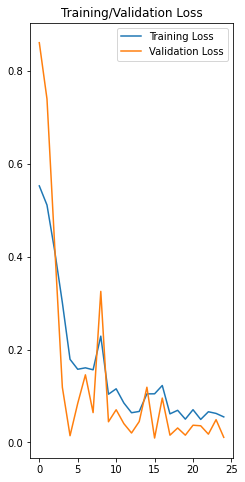

Epoch 1/25
27/27 [==============================] - 0s 5ms/step - loss: 0.1527 - mae: 0.1513 - rmse: 0.1527 - val_loss: 0.1293 - val_mae: 0.1289 - val_rmse: 0.1293
Epoch 2/25
27/27 [==============================] - 0s 4ms/step - loss: 0.1059 - mae: 0.1044 - rmse: 0.1059 - val_loss: 0.1836 - val_mae: 0.1824 - val_rmse: 0.1836
Epoch 3/25
27/27 [==============================] - 0s 5ms/step - loss: 0.1301 - mae: 0.1285 - rmse: 0.1301 - val_loss: 0.1199 - val_mae: 0.1188 - val_rmse: 0.1199
Epoch 4/25
27/27 [==============================] - 0s 5ms/step - loss: 0.1149 - mae: 0.1142 - rmse: 0.1149 - val_loss: 0.1759 - val_mae: 0.1757 - val_rmse: 0.1759
Epoch 5/25
27/27 [==============================] - 0s 4ms/step - loss: 0.1039 - mae: 0.1032 - rmse: 0.1039 - val_loss: 0.2357 - val_mae: 0.2356 - val_rmse: 0.2357
Epoch 6/25
27/27 [==============================] - 0s 4ms/step - loss: 0.1029 - mae: 0.1010 - rmse: 0.1029 - val_loss: 0.1678 - val_mae: 0.1664 - val_rmse: 0.1678
Epoch 7/25
27/27

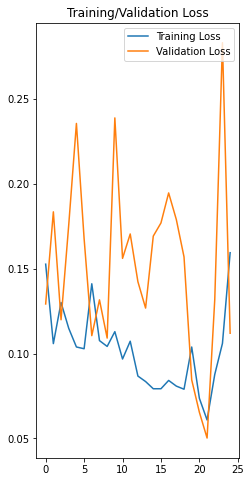

Epoch 1/25
40/40 [==============================] - 0s 5ms/step - loss: 0.1077 - mae: 0.1069 - rmse: 0.1077 - val_loss: 0.8742 - val_mae: 0.8742 - val_rmse: 0.8742
Epoch 2/25
40/40 [==============================] - 0s 5ms/step - loss: 0.0876 - mae: 0.0865 - rmse: 0.0876 - val_loss: 0.8121 - val_mae: 0.8120 - val_rmse: 0.8121
Epoch 3/25
40/40 [==============================] - 0s 5ms/step - loss: 0.0756 - mae: 0.0749 - rmse: 0.0756 - val_loss: 0.7177 - val_mae: 0.7174 - val_rmse: 0.7177
Epoch 4/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0670 - mae: 0.0660 - rmse: 0.0670 - val_loss: 0.5374 - val_mae: 0.5369 - val_rmse: 0.5374
Epoch 5/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0907 - mae: 0.0899 - rmse: 0.0907 - val_loss: 0.4274 - val_mae: 0.4268 - val_rmse: 0.4274
Epoch 6/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0719 - mae: 0.0709 - rmse: 0.0719 - val_loss: 0.5924 - val_mae: 0.5921 - val_rmse: 0.5924
Epoch 7/25
40/40

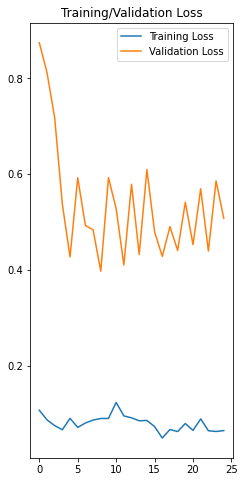

[array([[5969.749 , 5887.905 , 6094.846 , 5912.3965, 6029.4727, 6103.3184,
        5891.216 , 5969.857 , 5848.3994, 5881.5986, 6142.892 , 5857.6816,
        6127.979 , 5858.6157, 6024.707 , 5919.455 , 5816.5713, 6049.896 ,
        5827.8213, 5830.2915, 5861.648 , 6057.497 , 5835.784 , 6002.1436,
        5890.0566, 6021.655 , 5863.829 , 6042.1836, 6058.841 , 5918.7   ,
        5944.57  , 6182.927 , 5925.8193, 5663.9673, 5957.9326, 5891.7134,
        5921.1255, 6070.5195, 6058.2285, 5931.714 , 6052.7646, 6081.671 ,
        5898.275 , 6064.1904, 5910.0513, 6016.027 , 5940.5796, 5965.1787,
        5849.0493, 5863.7104, 5773.727 , 6068.443 , 5863.968 , 5959.861 ,
        5923.5034, 6021.063 , 5793.452 , 5943.5923, 5974.1924, 5937.9106,
        6107.162 , 5875.212 , 6025.209 , 5900.517 , 5858.0737, 5863.7026,
        6085.6357, 5797.632 , 6023.203 , 5901.328 , 5827.162 , 6042.3125,
        5941.3745, 5809.1606, 5897.5825, 5981.71  , 6155.103 , 5971.052 ,
        5922.041 , 6008.1045, 6015.29

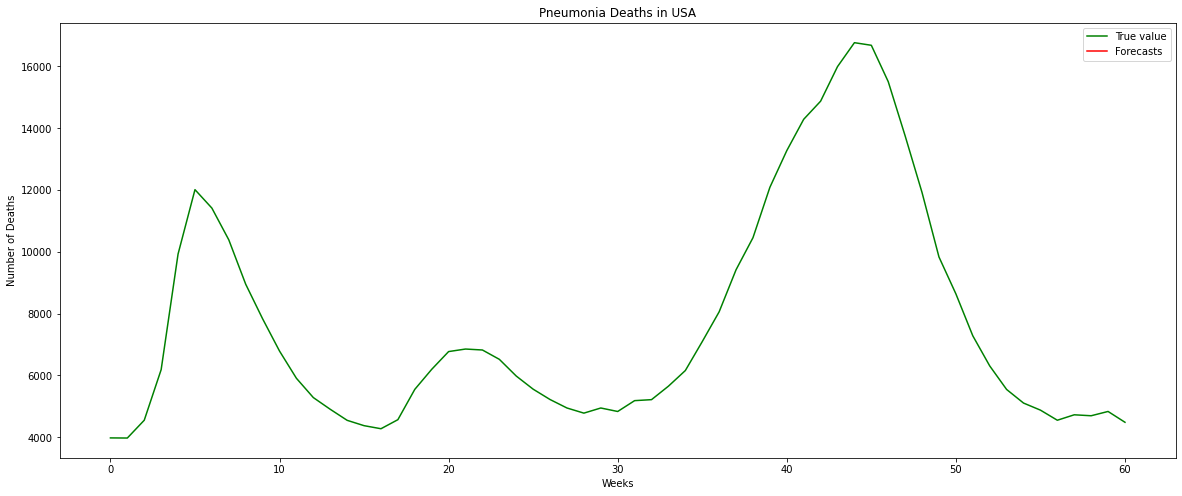

Epoch 1/50
8/8 [==============================] - 4s 123ms/step - loss: 0.5834 - mae: 0.5619 - rmse: 0.6054 - val_loss: 0.9042 - val_mae: 0.9040 - val_rmse: 0.9042
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5817 - mae: 0.5602 - rmse: 0.6036 - val_loss: 0.9015 - val_mae: 0.9013 - val_rmse: 0.9015
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5799 - mae: 0.5584 - rmse: 0.6017 - val_loss: 0.8986 - val_mae: 0.8984 - val_rmse: 0.8986
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.5780 - mae: 0.5565 - rmse: 0.5997 - val_loss: 0.8955 - val_mae: 0.8952 - val_rmse: 0.8955
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.5760 - mae: 0.5544 - rmse: 0.5976 - val_loss: 0.8921 - val_mae: 0.8917 - val_rmse: 0.8921
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: 0.5737 - mae: 0.5522 - rmse: 0.5953 - val_loss: 0.8882 - val_mae: 0.8877 - val_rmse: 0.8882
Epoch 7/50
8/8 [==========

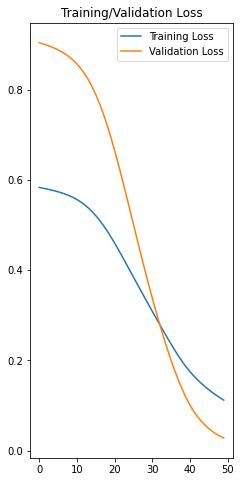

Epoch 1/50
14/14 [==============================] - 0s 9ms/step - loss: 0.1301 - mae: 0.1201 - rmse: 0.1267 - val_loss: 0.0810 - val_mae: 0.0770 - val_rmse: 0.0766
Epoch 2/50
14/14 [==============================] - 0s 9ms/step - loss: 0.1224 - mae: 0.1139 - rmse: 0.1204 - val_loss: 0.1065 - val_mae: 0.1039 - val_rmse: 0.1019
Epoch 3/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1190 - mae: 0.1109 - rmse: 0.1171 - val_loss: 0.1051 - val_mae: 0.1027 - val_rmse: 0.1004
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1136 - mae: 0.1058 - rmse: 0.1120 - val_loss: 0.1054 - val_mae: 0.1030 - val_rmse: 0.1005
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1082 - mae: 0.1011 - rmse: 0.1071 - val_loss: 0.1139 - val_mae: 0.1117 - val_rmse: 0.1087
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 0.1042 - mae: 0.0973 - rmse: 0.1035 - val_loss: 0.1207 - val_mae: 0.1186 - val_rmse: 0.1153
Epoch 7/50
14/14

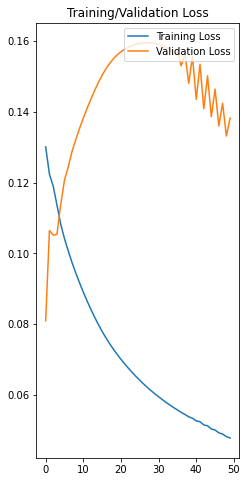

Epoch 1/50
20/20 [==============================] - 3s 50ms/step - loss: 0.0845 - mae: 0.0803 - rmse: 0.0845 - val_loss: 0.9065 - val_mae: 0.9038 - val_rmse: 0.9065
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0880 - mae: 0.0824 - rmse: 0.0880 - val_loss: 0.9069 - val_mae: 0.9043 - val_rmse: 0.9069
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0798 - mae: 0.0758 - rmse: 0.0798 - val_loss: 0.9074 - val_mae: 0.9047 - val_rmse: 0.9074
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0786 - mae: 0.0746 - rmse: 0.0786 - val_loss: 0.9079 - val_mae: 0.9053 - val_rmse: 0.9079
Epoch 5/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0741 - mae: 0.0701 - rmse: 0.0741 - val_loss: 0.9079 - val_mae: 0.9053 - val_rmse: 0.9079
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0719 - mae: 0.0682 - rmse: 0.0719 - val_loss: 0.9079 - val_mae: 0.9053 - val_rmse: 0.9079
Epoch 7/50
20/2

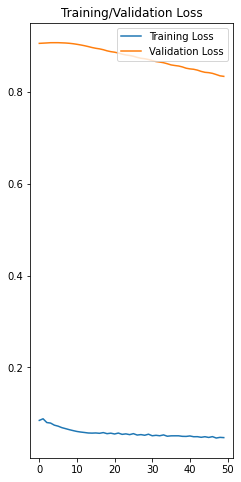

[array([[7842.1416, 8028.414 , 7629.922 , 7722.65  , 7916.6943, 7573.097 ,
        7863.0796, 7882.6094, 7665.682 , 7791.396 , 7722.1055, 7596.917 ,
        7971.0103, 7515.443 , 7956.348 , 7551.675 , 7990.9053, 7972.2095,
        7528.756 , 7843.8916, 7989.1123, 7839.552 , 7792.149 , 7458.3643,
        7589.998 , 7841.284 , 7621.6104, 7752.4604, 7846.605 , 7690.9795,
        7659.8784, 7846.5596, 7711.8877, 7793.4126, 7564.6265, 7778.832 ,
        7713.128 , 7784.395 , 7442.5654, 7832.4194, 7853.596 , 7932.1055,
        8093.8413, 7683.5366, 7868.4053, 7996.5566, 7542.288 , 7840.847 ,
        7700.546 , 7728.028 , 8009.9824, 7715.861 , 7707.9546, 7894.767 ,
        8032.266 , 7599.735 , 7798.7793, 7759.927 , 7625.9517, 7675.1323,
        7572.7305, 7854.2236, 7991.504 , 7588.1597, 7618.2544, 7669.84  ,
        7431.6113, 7769.6895, 7597.768 , 7834.988 , 7700.9585, 8015.974 ,
        7791.0522, 7878.4043, 7840.7573, 7810.2144, 7726.894 , 7438.933 ,
        7798.283 , 7727.36  , 7622.98

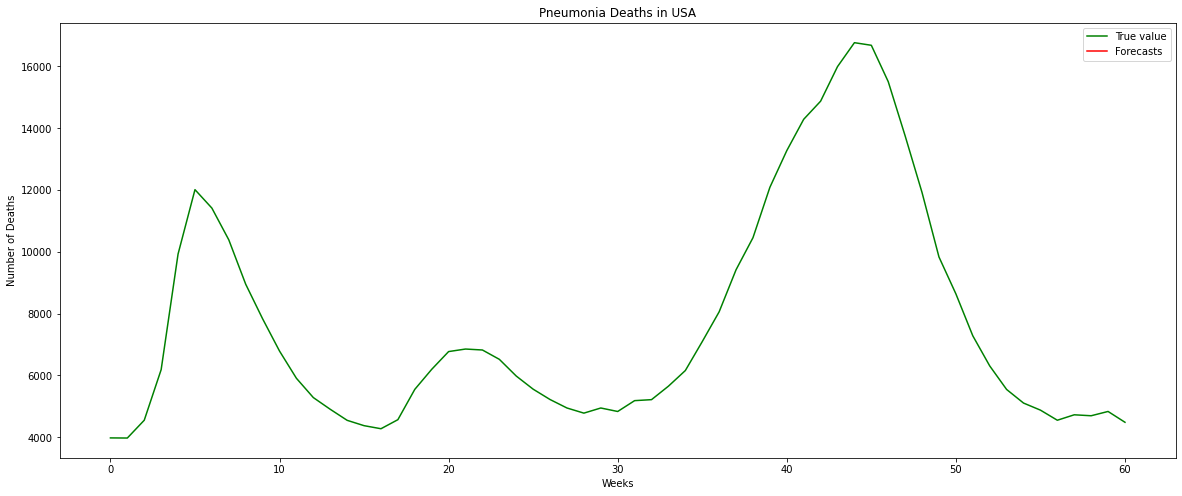

Epoch 1/100
5/5 [==============================] - 4s 209ms/step - loss: 0.5813 - mae: 0.5632 - rmse: 0.5813 - val_loss: 0.9077 - val_mae: 0.9076 - val_rmse: 0.9077
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.5812 - mae: 0.5631 - rmse: 0.5812 - val_loss: 0.9076 - val_mae: 0.9074 - val_rmse: 0.9076
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 0.5811 - mae: 0.5630 - rmse: 0.5811 - val_loss: 0.9074 - val_mae: 0.9073 - val_rmse: 0.9074
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.5810 - mae: 0.5629 - rmse: 0.5810 - val_loss: 0.9072 - val_mae: 0.9071 - val_rmse: 0.9072
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.5809 - mae: 0.5627 - rmse: 0.5809 - val_loss: 0.9070 - val_mae: 0.9069 - val_rmse: 0.9070
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.5808 - mae: 0.5626 - rmse: 0.5808 - val_loss: 0.9069 - val_mae: 0.9067 - val_rmse: 0.9069
Epoch 7/100
5/5

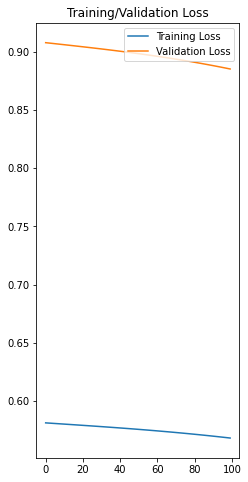

Epoch 1/100
9/9 [==============================] - 1s 104ms/step - loss: 0.6264 - mae: 0.6144 - rmse: 0.6264 - val_loss: 0.8211 - val_mae: 0.8203 - val_rmse: 0.8211
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6258 - mae: 0.6138 - rmse: 0.6258 - val_loss: 0.8204 - val_mae: 0.8195 - val_rmse: 0.8204
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6252 - mae: 0.6132 - rmse: 0.6252 - val_loss: 0.8196 - val_mae: 0.8187 - val_rmse: 0.8196
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6246 - mae: 0.6125 - rmse: 0.6246 - val_loss: 0.8187 - val_mae: 0.8179 - val_rmse: 0.8187
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6239 - mae: 0.6118 - rmse: 0.6239 - val_loss: 0.8179 - val_mae: 0.8170 - val_rmse: 0.8179
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6233 - mae: 0.6111 - rmse: 0.6233 - val_loss: 0.8170 - val_mae: 0.8161 - val_rmse: 0.8170
Epoch 7/100
9/9 [===

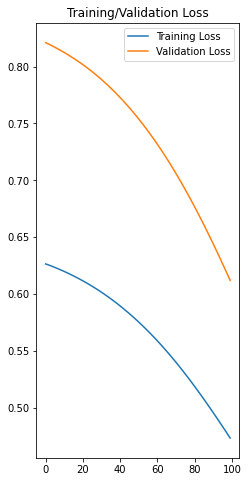

Epoch 1/100
14/14 [==============================] - 2s 10ms/step - loss: 0.4611 - mae: 0.4364 - rmse: 0.4618 - val_loss: 0.9120 - val_mae: 0.9055 - val_rmse: 0.9398
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4574 - mae: 0.4322 - rmse: 0.4583 - val_loss: 0.9119 - val_mae: 0.9054 - val_rmse: 0.9397
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4539 - mae: 0.4282 - rmse: 0.4549 - val_loss: 0.9117 - val_mae: 0.9052 - val_rmse: 0.9395
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4504 - mae: 0.4242 - rmse: 0.4516 - val_loss: 0.9116 - val_mae: 0.9050 - val_rmse: 0.9394
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4469 - mae: 0.4202 - rmse: 0.4482 - val_loss: 0.9114 - val_mae: 0.9048 - val_rmse: 0.9392
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4433 - mae: 0.4161 - rmse: 0.4448 - val_loss: 0.9112 - val_mae: 0.9046 - val_rmse: 0.9390
Epoch 7/1

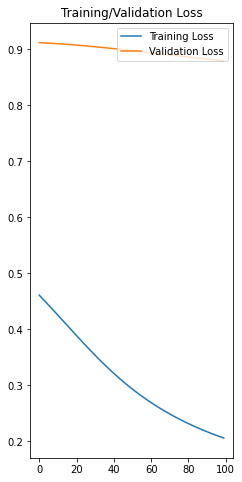

[array([[7053.317 , 7140.839 , 6819.967 , 7828.8066, 7312.367 , 7343.2466,
        6851.9253, 7154.5312, 6976.244 , 7031.0913, 7518.6924, 7117.0205,
        7038.3765, 6990.081 , 7126.4453, 7088.985 , 7582.7095, 7853.2095,
        7029.749 , 7326.926 , 8159.0337, 7120.1274, 7223.822 , 7074.0156,
        7696.6665, 7629.898 , 7167.355 , 6946.0537, 7744.7495, 7055.657 ,
        7607.7993, 7002.173 , 7189.1523, 7432.0903, 7128.12  , 6876.214 ,
        6909.854 , 8174.1284, 7073.908 , 6953.5796, 7063.575 , 7110.595 ,
        8233.509 , 7144.395 , 8236.87  , 7246.425 , 7264.0913, 7068.8916,
        7022.8677, 7499.518 , 6861.2583, 7762.5444, 7071.445 , 6704.164 ,
        6852.1826, 7252.3623, 7486.307 , 7868.712 , 7400.3105, 6826.187 ,
        7280.773 , 7329.7954, 6886.927 , 7285.0776, 7373.7505, 7172.7754,
        6997.954 , 7657.7324, 7126.6123, 7959.4585, 7323.581 , 7515.8555,
        7219.447 , 7690.898 , 6805.5977, 7162.189 , 6949.2725, 7267.959 ,
        7699.4053, 6913.9307, 7006.80

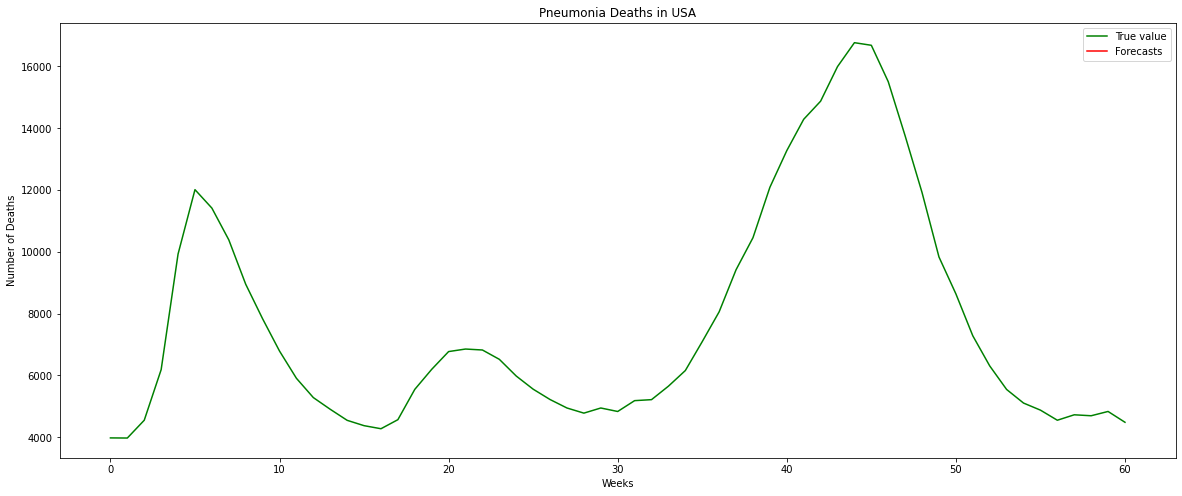

Epoch 1/60
14/14 [==============================] - 4s 65ms/step - loss: 0.5291 - mae: 0.5272 - rmse: 0.5291 - val_loss: 0.8835 - val_mae: 0.8829 - val_rmse: 0.8835
Epoch 2/60
14/14 [==============================] - 0s 6ms/step - loss: 0.5047 - mae: 0.5014 - rmse: 0.5047 - val_loss: 0.8179 - val_mae: 0.8155 - val_rmse: 0.8179
Epoch 3/60
14/14 [==============================] - 0s 5ms/step - loss: 0.4545 - mae: 0.4491 - rmse: 0.4545 - val_loss: 0.6587 - val_mae: 0.6526 - val_rmse: 0.6587
Epoch 4/60
14/14 [==============================] - 0s 6ms/step - loss: 0.3623 - mae: 0.3532 - rmse: 0.3623 - val_loss: 0.3567 - val_mae: 0.3474 - val_rmse: 0.3567
Epoch 5/60
14/14 [==============================] - 0s 7ms/step - loss: 0.2665 - mae: 0.2622 - rmse: 0.2665 - val_loss: 0.1217 - val_mae: 0.1198 - val_rmse: 0.1217
Epoch 6/60
14/14 [==============================] - 0s 6ms/step - loss: 0.1741 - mae: 0.1691 - rmse: 0.1741 - val_loss: 0.1532 - val_mae: 0.1517 - val_rmse: 0.1532
Epoch 7/60
14/1

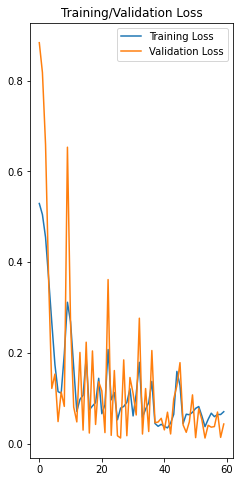

Epoch 1/60
27/27 [==============================] - 0s 7ms/step - loss: 0.1207 - mae: 0.1184 - rmse: 0.1207 - val_loss: 0.2295 - val_mae: 0.2279 - val_rmse: 0.2295
Epoch 2/60
27/27 [==============================] - 0s 6ms/step - loss: 0.1211 - mae: 0.1177 - rmse: 0.1211 - val_loss: 0.1970 - val_mae: 0.1956 - val_rmse: 0.1970
Epoch 3/60
27/27 [==============================] - 0s 6ms/step - loss: 0.1594 - mae: 0.1585 - rmse: 0.1594 - val_loss: 0.0899 - val_mae: 0.0896 - val_rmse: 0.0899
Epoch 4/60
27/27 [==============================] - 0s 6ms/step - loss: 0.1398 - mae: 0.1393 - rmse: 0.1398 - val_loss: 0.0578 - val_mae: 0.0570 - val_rmse: 0.0578
Epoch 5/60
27/27 [==============================] - 0s 6ms/step - loss: 0.1133 - mae: 0.1127 - rmse: 0.1133 - val_loss: 0.0900 - val_mae: 0.0897 - val_rmse: 0.0900
Epoch 6/60
27/27 [==============================] - 0s 6ms/step - loss: 0.1084 - mae: 0.1071 - rmse: 0.1084 - val_loss: 0.1171 - val_mae: 0.1167 - val_rmse: 0.1171
Epoch 7/60
27/27

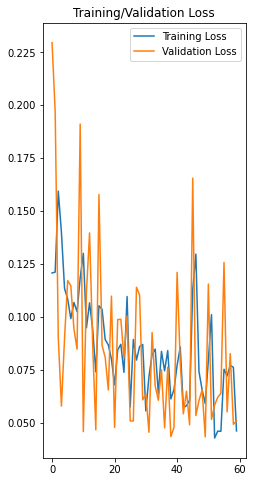

Epoch 1/60
39/39 [==============================] - 0s 7ms/step - loss: 0.0913 - mae: 0.0901 - rmse: 0.0913 - val_loss: 0.7542 - val_mae: 0.7539 - val_rmse: 0.7542
Epoch 2/60
39/39 [==============================] - 0s 7ms/step - loss: 0.1015 - mae: 0.1006 - rmse: 0.1015 - val_loss: 0.6487 - val_mae: 0.6478 - val_rmse: 0.6487
Epoch 3/60
39/39 [==============================] - 0s 6ms/step - loss: 0.0787 - mae: 0.0773 - rmse: 0.0787 - val_loss: 0.6361 - val_mae: 0.6356 - val_rmse: 0.6361
Epoch 4/60
39/39 [==============================] - 0s 6ms/step - loss: 0.0621 - mae: 0.0611 - rmse: 0.0621 - val_loss: 0.4989 - val_mae: 0.4974 - val_rmse: 0.4989
Epoch 5/60
39/39 [==============================] - 0s 7ms/step - loss: 0.0784 - mae: 0.0777 - rmse: 0.0784 - val_loss: 0.2524 - val_mae: 0.2482 - val_rmse: 0.2524
Epoch 6/60
39/39 [==============================] - 0s 6ms/step - loss: 0.0920 - mae: 0.0911 - rmse: 0.0920 - val_loss: 0.6920 - val_mae: 0.6917 - val_rmse: 0.6920
Epoch 7/60
39/39

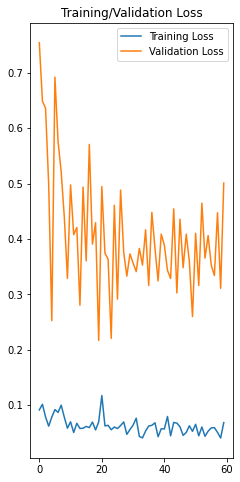

[array([[5720.0933, 5707.3247, 5712.2383, 5729.924 , 5644.694 , 5795.356 ,
        5797.6665, 5771.4204, 5653.176 , 5759.61  , 5801.967 , 5736.548 ,
        5678.211 , 5725.3945, 5712.2563, 5577.429 , 5750.29  , 5685.2944,
        5623.467 , 5703.1123, 5807.8135, 5696.1333, 5767.494 , 5597.9956,
        5706.7207, 5691.444 , 5780.2183, 5668.4775, 5668.0444, 5743.915 ,
        5693.7295, 5767.483 , 5708.1616, 5648.254 , 5707.888 , 5718.5957,
        5693.8037, 5700.4185, 5855.6675, 5713.147 , 5778.3584, 5731.166 ,
        5747.7124, 5732.664 , 5712.937 , 5627.2856, 5708.7905, 5665.829 ,
        5726.2236, 5635.586 , 5867.1743, 5693.7803, 5732.4077, 5751.7905,
        5672.6924, 5626.6084, 5710.618 , 5704.9375, 5796.7017, 5753.388 ,
        5760.036 , 5655.137 , 5733.6396, 5789.924 , 5735.537 , 5844.763 ,
        5695.4634, 5780.99  , 5733.532 , 5710.231 , 5675.4937, 5795.4478,
        5808.776 , 5722.0083, 5764.8354, 5796.5244, 5721.2305, 5783.938 ,
        5678.854 , 5766.528 , 5721.93

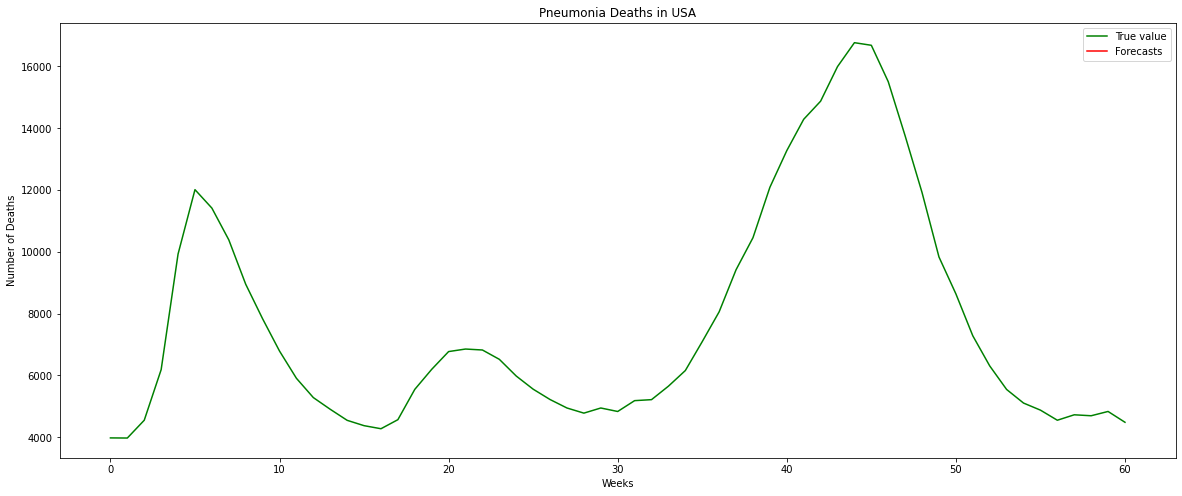

Epoch 1/90
7/7 [==============================] - 4s 150ms/step - loss: 0.5455 - mae: 0.5331 - rmse: 0.5455 - val_loss: 0.9083 - val_mae: 0.9075 - val_rmse: 0.9083
Epoch 2/90
7/7 [==============================] - 0s 10ms/step - loss: 0.5429 - mae: 0.5305 - rmse: 0.5429 - val_loss: 0.9047 - val_mae: 0.9040 - val_rmse: 0.9047
Epoch 3/90
7/7 [==============================] - 0s 10ms/step - loss: 0.5407 - mae: 0.5281 - rmse: 0.5407 - val_loss: 0.9011 - val_mae: 0.9005 - val_rmse: 0.9011
Epoch 4/90
7/7 [==============================] - 0s 10ms/step - loss: 0.5386 - mae: 0.5258 - rmse: 0.5386 - val_loss: 0.8975 - val_mae: 0.8969 - val_rmse: 0.8975
Epoch 5/90
7/7 [==============================] - 0s 9ms/step - loss: 0.5366 - mae: 0.5235 - rmse: 0.5366 - val_loss: 0.8938 - val_mae: 0.8932 - val_rmse: 0.8938
Epoch 6/90
7/7 [==============================] - 0s 12ms/step - loss: 0.5345 - mae: 0.5212 - rmse: 0.5345 - val_loss: 0.8899 - val_mae: 0.8893 - val_rmse: 0.8899
Epoch 7/90
7/7 [======

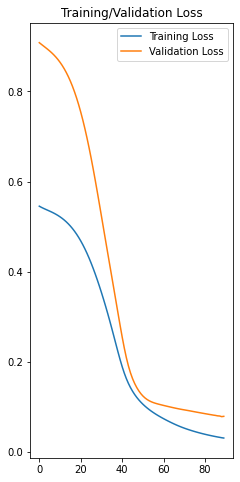

Epoch 1/90
14/14 [==============================] - 4s 77ms/step - loss: 0.0767 - mae: 0.0710 - rmse: 0.0822 - val_loss: 0.2653 - val_mae: 0.2627 - val_rmse: 0.2653
Epoch 2/90
14/14 [==============================] - 0s 9ms/step - loss: 0.0771 - mae: 0.0722 - rmse: 0.0823 - val_loss: 0.2578 - val_mae: 0.2554 - val_rmse: 0.2578
Epoch 3/90
14/14 [==============================] - 0s 12ms/step - loss: 0.0754 - mae: 0.0712 - rmse: 0.0791 - val_loss: 0.2185 - val_mae: 0.2160 - val_rmse: 0.2185
Epoch 4/90
14/14 [==============================] - 0s 12ms/step - loss: 0.0754 - mae: 0.0703 - rmse: 0.0806 - val_loss: 0.2566 - val_mae: 0.2542 - val_rmse: 0.2566
Epoch 5/90
14/14 [==============================] - 0s 10ms/step - loss: 0.0740 - mae: 0.0692 - rmse: 0.0773 - val_loss: 0.2066 - val_mae: 0.2039 - val_rmse: 0.2066
Epoch 6/90
14/14 [==============================] - 0s 12ms/step - loss: 0.0726 - mae: 0.0677 - rmse: 0.0774 - val_loss: 0.2411 - val_mae: 0.2386 - val_rmse: 0.2411
Epoch 7/90


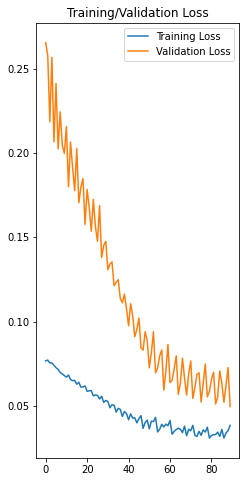

Epoch 1/90
20/20 [==============================] - 0s 11ms/step - loss: 0.0624 - mae: 0.0562 - rmse: 0.0715 - val_loss: 0.9176 - val_mae: 0.9139 - val_rmse: 0.9176
Epoch 2/90
20/20 [==============================] - 0s 8ms/step - loss: 0.0638 - mae: 0.0577 - rmse: 0.0727 - val_loss: 0.9140 - val_mae: 0.9103 - val_rmse: 0.9140
Epoch 3/90
20/20 [==============================] - 0s 9ms/step - loss: 0.0669 - mae: 0.0612 - rmse: 0.0757 - val_loss: 0.9101 - val_mae: 0.9064 - val_rmse: 0.9101
Epoch 4/90
20/20 [==============================] - 0s 9ms/step - loss: 0.0706 - mae: 0.0655 - rmse: 0.0791 - val_loss: 0.9044 - val_mae: 0.9006 - val_rmse: 0.9044
Epoch 5/90
20/20 [==============================] - 0s 10ms/step - loss: 0.0580 - mae: 0.0524 - rmse: 0.0667 - val_loss: 0.8991 - val_mae: 0.8953 - val_rmse: 0.8991
Epoch 6/90
20/20 [==============================] - 0s 9ms/step - loss: 0.0593 - mae: 0.0540 - rmse: 0.0679 - val_loss: 0.8948 - val_mae: 0.8910 - val_rmse: 0.8948
Epoch 7/90
20/

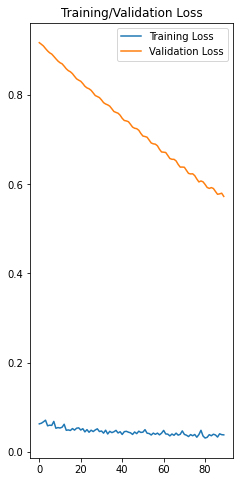

[array([[8895.461 , 9135.391 , 8613.059 , 8725.595 , 8847.117 , 8873.819 ,
        8647.79  , 8565.218 , 8239.679 , 8397.832 , 8922.902 , 8637.678 ,
        8573.484 , 8432.276 , 8464.675 , 8615.224 , 9015.938 , 9091.245 ,
        8633.034 , 8665.422 , 8914.487 , 8621.476 , 8865.238 , 8789.466 ,
        8619.684 , 9058.724 , 8619.626 , 8865.764 , 8808.604 , 8948.662 ,
        8452.7295, 8866.885 , 8822.536 , 8582.788 , 8713.137 , 9051.775 ,
        8684.367 , 9057.106 , 9128.742 , 8839.498 , 8724.169 , 8942.553 ,
        8765.8125, 8844.305 , 8640.222 , 8940.834 , 8514.094 , 8761.847 ,
        8955.534 , 8859.684 , 8806.378 , 8808.075 , 9036.605 , 9397.942 ,
        8988.276 , 8652.078 , 8951.855 , 8962.495 , 8988.648 , 8663.698 ,
        8848.903 , 8947.3   , 8733.947 , 8666.692 , 9162.975 , 8477.398 ,
        8355.05  , 9271.531 , 8520.6455, 8678.812 , 9041.978 , 8602.044 ,
        8637.027 , 9251.646 , 8728.044 , 8814.126 , 8193.142 , 8413.239 ,
        8832.799 , 8735.778 , 8741.29

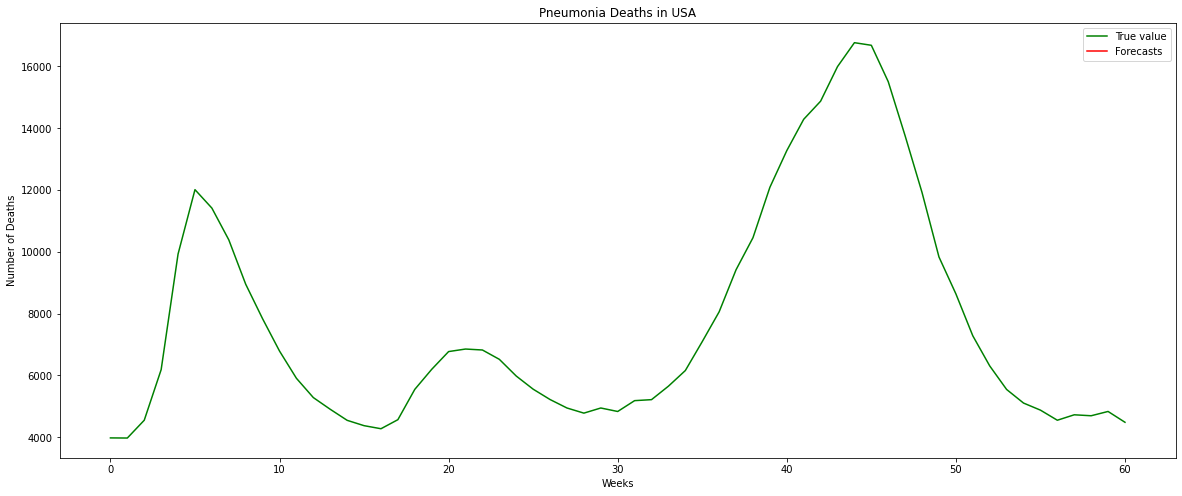

Epoch 1/120
5/5 [==============================] - 4s 230ms/step - loss: 0.5684 - mae: 0.5330 - rmse: 0.5921 - val_loss: 0.9072 - val_mae: 0.9062 - val_rmse: 0.9072
Epoch 2/120
5/5 [==============================] - 0s 13ms/step - loss: 0.5682 - mae: 0.5328 - rmse: 0.5919 - val_loss: 0.9069 - val_mae: 0.9058 - val_rmse: 0.9069
Epoch 3/120
5/5 [==============================] - 0s 13ms/step - loss: 0.5680 - mae: 0.5325 - rmse: 0.5917 - val_loss: 0.9065 - val_mae: 0.9054 - val_rmse: 0.9065
Epoch 4/120
5/5 [==============================] - 0s 14ms/step - loss: 0.5677 - mae: 0.5323 - rmse: 0.5914 - val_loss: 0.9061 - val_mae: 0.9051 - val_rmse: 0.9061
Epoch 5/120
5/5 [==============================] - 0s 15ms/step - loss: 0.5675 - mae: 0.5321 - rmse: 0.5912 - val_loss: 0.9057 - val_mae: 0.9047 - val_rmse: 0.9057
Epoch 6/120
5/5 [==============================] - 0s 15ms/step - loss: 0.5673 - mae: 0.5318 - rmse: 0.5909 - val_loss: 0.9053 - val_mae: 0.9043 - val_rmse: 0.9053
Epoch 7/120
5/5

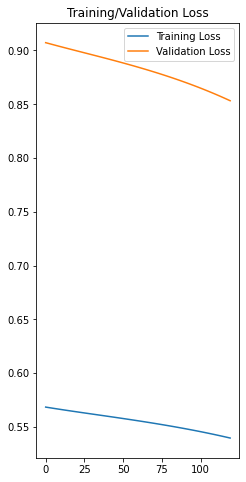

Epoch 1/120
9/9 [==============================] - 2s 11ms/step - loss: 0.6088 - mae: 0.5875 - rmse: 0.6088 - val_loss: 0.7952 - val_mae: 0.7935 - val_rmse: 0.7952
Epoch 2/120
9/9 [==============================] - 0s 8ms/step - loss: 0.6077 - mae: 0.5864 - rmse: 0.6077 - val_loss: 0.7937 - val_mae: 0.7919 - val_rmse: 0.7937
Epoch 3/120
9/9 [==============================] - 0s 8ms/step - loss: 0.6064 - mae: 0.5851 - rmse: 0.6064 - val_loss: 0.7920 - val_mae: 0.7902 - val_rmse: 0.7920
Epoch 4/120
9/9 [==============================] - 0s 8ms/step - loss: 0.6051 - mae: 0.5837 - rmse: 0.6051 - val_loss: 0.7903 - val_mae: 0.7884 - val_rmse: 0.7903
Epoch 5/120
9/9 [==============================] - 0s 10ms/step - loss: 0.6037 - mae: 0.5822 - rmse: 0.6037 - val_loss: 0.7885 - val_mae: 0.7865 - val_rmse: 0.7885
Epoch 6/120
9/9 [==============================] - 0s 8ms/step - loss: 0.6024 - mae: 0.5808 - rmse: 0.6024 - val_loss: 0.7866 - val_mae: 0.7846 - val_rmse: 0.7866
Epoch 7/120
9/9 [===

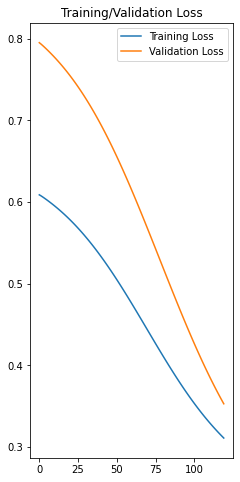

Epoch 1/120
13/13 [==============================] - 0s 10ms/step - loss: 0.2975 - mae: 0.2627 - rmse: 0.2975 - val_loss: 0.9141 - val_mae: 0.9071 - val_rmse: 0.9467
Epoch 2/120
13/13 [==============================] - 0s 8ms/step - loss: 0.2945 - mae: 0.2597 - rmse: 0.2945 - val_loss: 0.9138 - val_mae: 0.9068 - val_rmse: 0.9464
Epoch 3/120
13/13 [==============================] - 0s 8ms/step - loss: 0.2915 - mae: 0.2568 - rmse: 0.2915 - val_loss: 0.9134 - val_mae: 0.9064 - val_rmse: 0.9461
Epoch 4/120
13/13 [==============================] - 0s 9ms/step - loss: 0.2887 - mae: 0.2540 - rmse: 0.2887 - val_loss: 0.9130 - val_mae: 0.9059 - val_rmse: 0.9457
Epoch 5/120
13/13 [==============================] - 0s 9ms/step - loss: 0.2859 - mae: 0.2513 - rmse: 0.2859 - val_loss: 0.9126 - val_mae: 0.9055 - val_rmse: 0.9454
Epoch 6/120
13/13 [==============================] - 0s 9ms/step - loss: 0.2832 - mae: 0.2486 - rmse: 0.2832 - val_loss: 0.9122 - val_mae: 0.9051 - val_rmse: 0.9450
Epoch 7/1

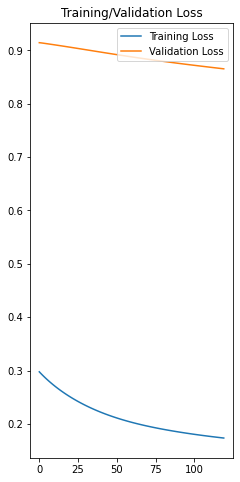

[array([[8484.922 , 8927.038 , 8679.017 , 8693.69  , 8765.903 , 9157.487 ,
        8519.221 , 9285.789 , 8889.989 , 8684.08  , 8608.95  , 8842.575 ,
        8740.488 , 8652.476 , 8794.595 , 8901.221 , 8759.303 , 9132.628 ,
        8481.807 , 9179.488 , 8805.514 , 8727.42  , 8632.878 , 8768.011 ,
        8725.737 , 8792.345 , 8431.242 , 8874.351 , 8997.819 , 8599.934 ,
        8577.938 , 8933.588 , 8615.316 , 9603.888 , 8888.496 , 8567.8545,
        8693.058 , 8592.521 , 8646.081 , 8983.86  , 9070.215 , 9134.019 ,
        8725.548 , 8393.7705, 8471.927 , 8814.229 , 8875.706 , 9107.643 ,
        8888.36  , 8872.45  , 9007.553 , 9177.1045, 8605.514 , 8914.707 ,
        8810.638 , 8752.5625, 8957.114 , 9034.259 , 8971.269 , 8770.654 ,
        8924.323 , 8820.6455, 9000.134 , 8604.546 , 8625.936 , 8628.428 ,
        8856.872 , 8605.82  , 8797.288 , 8792.321 , 9033.199 , 8843.817 ,
        8783.346 , 8561.119 , 9046.705 , 9017.118 , 9159.726 , 8690.857 ,
        8401.448 , 9089.109 , 9022.87

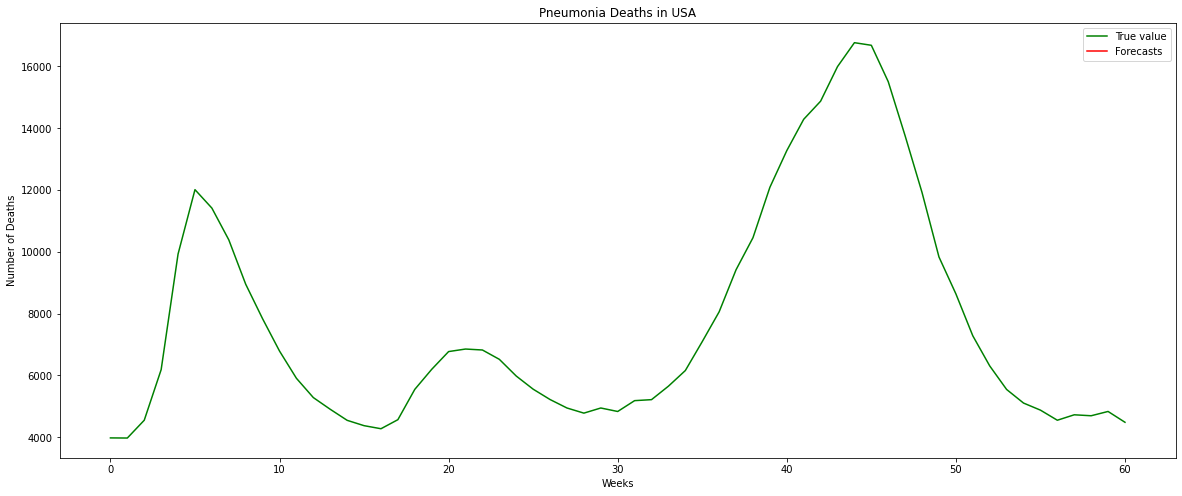

Epoch 1/50
12/12 [==============================] - 4s 81ms/step - loss: 0.4955 - mae: 0.4914 - rmse: 0.4955 - val_loss: 0.8853 - val_mae: 0.8824 - val_rmse: 0.8853
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4650 - mae: 0.4591 - rmse: 0.4650 - val_loss: 0.8255 - val_mae: 0.8225 - val_rmse: 0.8255
Epoch 3/50
12/12 [==============================] - 0s 9ms/step - loss: 0.4015 - mae: 0.3899 - rmse: 0.4015 - val_loss: 0.6786 - val_mae: 0.6687 - val_rmse: 0.6786
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 0.2984 - mae: 0.2816 - rmse: 0.2984 - val_loss: 0.5070 - val_mae: 0.5007 - val_rmse: 0.5070
Epoch 5/50
12/12 [==============================] - 0s 9ms/step - loss: 0.1992 - mae: 0.1874 - rmse: 0.1992 - val_loss: 0.4772 - val_mae: 0.4746 - val_rmse: 0.4772
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.1425 - mae: 0.1320 - rmse: 0.1425 - val_loss: 0.0913 - val_mae: 0.0864 - val_rmse: 0.0913
Epoch 7/50
12/1

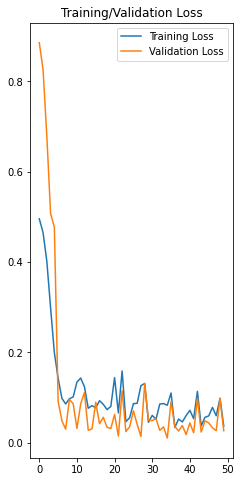

Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.1148 - mae: 0.1115 - rmse: 0.1148 - val_loss: 0.0687 - val_mae: 0.0588 - val_rmse: 0.0687
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.1754 - mae: 0.1710 - rmse: 0.1754 - val_loss: 0.1402 - val_mae: 0.1345 - val_rmse: 0.1402
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1637 - mae: 0.1596 - rmse: 0.1637 - val_loss: 0.1162 - val_mae: 0.1111 - val_rmse: 0.1162
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 0.1317 - mae: 0.1289 - rmse: 0.1317 - val_loss: 0.0779 - val_mae: 0.0757 - val_rmse: 0.0779
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1296 - mae: 0.1256 - rmse: 0.1296 - val_loss: 0.1904 - val_mae: 0.1886 - val_rmse: 0.1904
Epoch 6/50
25/25 [==============================] - 0s 8ms/step - loss: 0.1457 - mae: 0.1444 - rmse: 0.1457 - val_loss: 0.0951 - val_mae: 0.0949 - val_rmse: 0.0951
Epoch 7/50
25/25

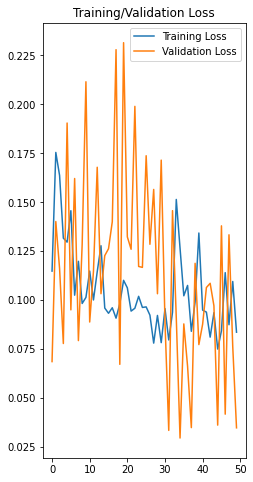

Epoch 1/50
37/37 [==============================] - 0s 8ms/step - loss: 0.1627 - mae: 0.1610 - rmse: 0.1627 - val_loss: 0.8436 - val_mae: 0.8394 - val_rmse: 0.8436
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.1345 - mae: 0.1323 - rmse: 0.1345 - val_loss: 0.5959 - val_mae: 0.5891 - val_rmse: 0.5959
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.1007 - mae: 0.0975 - rmse: 0.1007 - val_loss: 0.5062 - val_mae: 0.4989 - val_rmse: 0.5062
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0986 - mae: 0.0958 - rmse: 0.0986 - val_loss: 0.5712 - val_mae: 0.5671 - val_rmse: 0.5712
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0853 - mae: 0.0829 - rmse: 0.0853 - val_loss: 0.4808 - val_mae: 0.4729 - val_rmse: 0.4808
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0795 - mae: 0.0760 - rmse: 0.0795 - val_loss: 0.3041 - val_mae: 0.2922 - val_rmse: 0.3041
Epoch 7/50
37/37

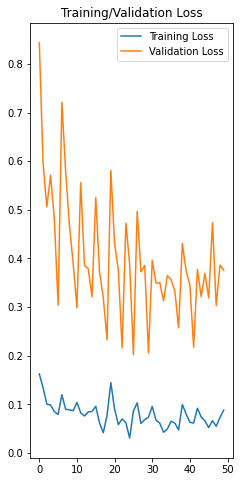

[array([[8186.6294, 8099.97  , 8304.905 , 7687.115 , 8391.455 , 8498.652 ,
        8075.56  , 8138.7505, 7659.1743, 7940.2827, 8320.011 , 8314.388 ,
        8309.001 , 8224.592 , 7972.8496, 8290.247 , 8398.0205, 8169.493 ,
        8036.0063, 7955.0835, 7972.7456, 8185.488 , 8091.4707, 8328.521 ,
        8072.0405, 8156.4424, 8411.613 , 8371.684 , 8295.395 , 8072.031 ,
        8069.6934, 8019.733 , 8231.42  , 7975.839 , 8335.345 , 8184.984 ,
        7744.4775, 8100.4097, 8173.8867, 8325.631 , 8165.2246, 8115.544 ,
        8025.639 , 8340.95  , 8154.7075, 8019.742 , 8094.9893, 8262.68  ,
        8004.727 , 8418.982 , 8202.402 , 7993.954 , 8168.445 , 8240.658 ,
        8341.987 , 8344.712 , 8122.7026, 8181.1206, 7981.247 , 8115.7383,
        8210.896 , 8141.108 , 8000.949 , 8075.8477, 8087.07  , 8222.232 ,
        8018.5303, 8031.228 , 8505.845 , 8319.394 , 8216.207 , 8173.033 ,
        8423.499 , 8373.731 , 7983.559 , 8325.037 , 7991.5693, 8094.597 ,
        8193.389 , 8115.5005, 8119.93

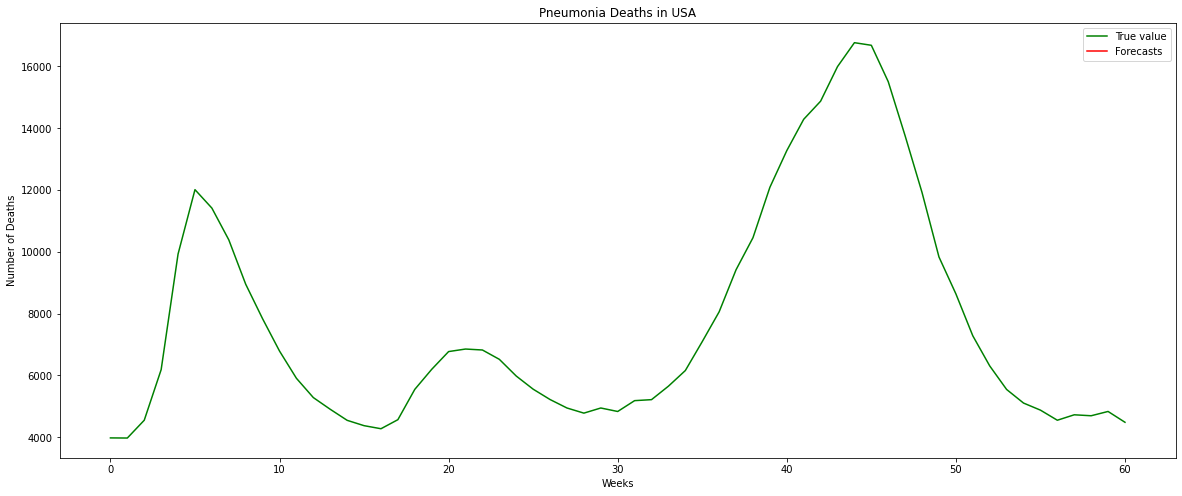

Epoch 1/90
6/6 [==============================] - 3s 164ms/step - loss: 0.5084 - mae: 0.4933 - rmse: 0.5084 - val_loss: 0.9087 - val_mae: 0.9064 - val_rmse: 0.9087
Epoch 2/90
6/6 [==============================] - 0s 11ms/step - loss: 0.5026 - mae: 0.4887 - rmse: 0.5026 - val_loss: 0.9040 - val_mae: 0.9021 - val_rmse: 0.9040
Epoch 3/90
6/6 [==============================] - 0s 13ms/step - loss: 0.4984 - mae: 0.4847 - rmse: 0.4984 - val_loss: 0.8995 - val_mae: 0.8979 - val_rmse: 0.8995
Epoch 4/90
6/6 [==============================] - 0s 13ms/step - loss: 0.4949 - mae: 0.4811 - rmse: 0.4949 - val_loss: 0.8952 - val_mae: 0.8937 - val_rmse: 0.8952
Epoch 5/90
6/6 [==============================] - 0s 11ms/step - loss: 0.4917 - mae: 0.4777 - rmse: 0.4917 - val_loss: 0.8911 - val_mae: 0.8896 - val_rmse: 0.8911
Epoch 6/90
6/6 [==============================] - 0s 11ms/step - loss: 0.4886 - mae: 0.4743 - rmse: 0.4886 - val_loss: 0.8870 - val_mae: 0.8853 - val_rmse: 0.8870
Epoch 7/90
6/6 [=====

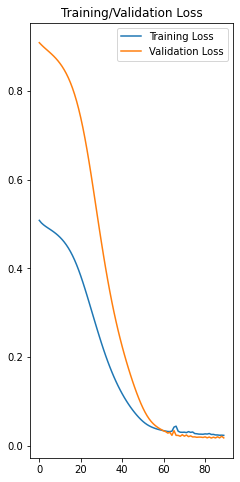

Epoch 1/90
13/13 [==============================] - 3s 78ms/step - loss: 0.0908 - mae: 0.0859 - rmse: 0.0931 - val_loss: 0.1391 - val_mae: 0.1312 - val_rmse: 0.1391
Epoch 2/90
13/13 [==============================] - 0s 11ms/step - loss: 0.0904 - mae: 0.0848 - rmse: 0.0935 - val_loss: 0.1521 - val_mae: 0.1468 - val_rmse: 0.1521
Epoch 3/90
13/13 [==============================] - 0s 12ms/step - loss: 0.0930 - mae: 0.0874 - rmse: 0.0938 - val_loss: 0.1027 - val_mae: 0.0967 - val_rmse: 0.1027
Epoch 4/90
13/13 [==============================] - 0s 13ms/step - loss: 0.0948 - mae: 0.0904 - rmse: 0.0971 - val_loss: 0.1390 - val_mae: 0.1346 - val_rmse: 0.1390
Epoch 5/90
13/13 [==============================] - 0s 13ms/step - loss: 0.0880 - mae: 0.0832 - rmse: 0.0889 - val_loss: 0.0981 - val_mae: 0.0932 - val_rmse: 0.0981
Epoch 6/90
13/13 [==============================] - 0s 12ms/step - loss: 0.0874 - mae: 0.0829 - rmse: 0.0900 - val_loss: 0.1360 - val_mae: 0.1321 - val_rmse: 0.1360
Epoch 7/90

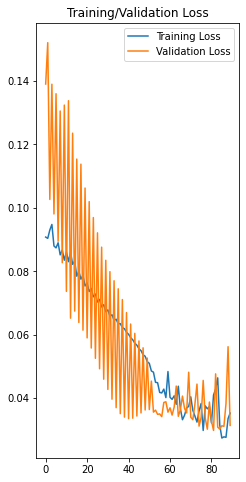

Epoch 1/90
19/19 [==============================] - 0s 13ms/step - loss: 0.0788 - mae: 0.0728 - rmse: 0.0890 - val_loss: 0.9016 - val_mae: 0.8963 - val_rmse: 0.9016
Epoch 2/90
19/19 [==============================] - 0s 11ms/step - loss: 0.1036 - mae: 0.0975 - rmse: 0.1125 - val_loss: 0.8797 - val_mae: 0.8742 - val_rmse: 0.8797
Epoch 3/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0836 - mae: 0.0784 - rmse: 0.0921 - val_loss: 0.8671 - val_mae: 0.8613 - val_rmse: 0.8671
Epoch 4/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0598 - mae: 0.0536 - rmse: 0.0683 - val_loss: 0.8493 - val_mae: 0.8434 - val_rmse: 0.8493
Epoch 5/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0590 - mae: 0.0528 - rmse: 0.0668 - val_loss: 0.8361 - val_mae: 0.8298 - val_rmse: 0.8361
Epoch 6/90
19/19 [==============================] - 0s 12ms/step - loss: 0.0556 - mae: 0.0501 - rmse: 0.0630 - val_loss: 0.8260 - val_mae: 0.8196 - val_rmse: 0.8260
Epoch 7/90

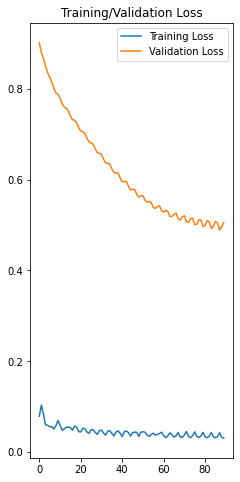

[array([[ 9839.061 ,  9883.712 ,  9293.23  , 10040.551 ,  9787.063 ,
         8934.53  , 10644.049 , 10638.714 ,  9696.406 ,  9431.1   ,
        10091.841 , 10218.701 ,  9808.825 , 10815.664 , 10043.416 ,
        10359.649 , 10933.904 , 10157.195 ,  9981.135 , 10479.675 ,
        10644.642 , 10720.459 , 11466.128 , 10964.578 , 10065.452 ,
        10084.564 , 11222.083 ,  9020.243 , 10218.569 , 11103.472 ,
        10458.297 , 10863.331 ,  9639.594 ,  9911.923 , 10887.333 ,
        10149.142 ,  9652.235 , 10126.465 , 11091.805 , 10158.96  ,
        10095.095 , 10684.057 , 10906.91  , 11987.249 ,  9878.497 ,
        10900.7295, 10481.63  , 10791.891 , 10418.628 , 10344.096 ,
        10358.476 ,  9551.497 , 10665.707 ,  9812.356 , 10429.366 ,
        10187.359 , 10865.008 , 10651.139 ,  9532.559 ,  9992.257 ,
        10087.508 , 10596.173 , 10650.932 , 11019.673 , 10215.476 ,
        10064.707 , 10001.365 , 10020.828 , 10275.492 , 10915.734 ,
        10681.017 , 10772.768 , 10829.432 , 107

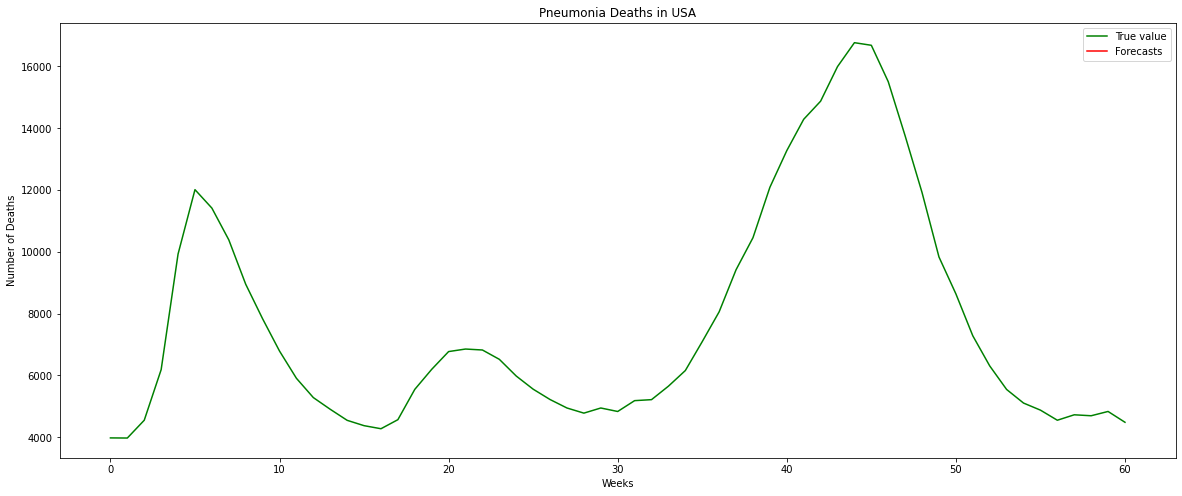

Epoch 1/120
4/4 [==============================] - 4s 270ms/step - loss: 0.5126 - mae: 0.4903 - rmse: 0.5126 - val_loss: 0.9101 - val_mae: 0.9072 - val_rmse: 0.9101
Epoch 2/120
4/4 [==============================] - 0s 17ms/step - loss: 0.5122 - mae: 0.4900 - rmse: 0.5122 - val_loss: 0.9098 - val_mae: 0.9070 - val_rmse: 0.9098
Epoch 3/120
4/4 [==============================] - 0s 16ms/step - loss: 0.5119 - mae: 0.4897 - rmse: 0.5119 - val_loss: 0.9095 - val_mae: 0.9067 - val_rmse: 0.9095
Epoch 4/120
4/4 [==============================] - 0s 16ms/step - loss: 0.5115 - mae: 0.4894 - rmse: 0.5115 - val_loss: 0.9091 - val_mae: 0.9064 - val_rmse: 0.9091
Epoch 5/120
4/4 [==============================] - 0s 17ms/step - loss: 0.5112 - mae: 0.4891 - rmse: 0.5112 - val_loss: 0.9088 - val_mae: 0.9061 - val_rmse: 0.9088
Epoch 6/120
4/4 [==============================] - 0s 23ms/step - loss: 0.5109 - mae: 0.4888 - rmse: 0.5109 - val_loss: 0.9084 - val_mae: 0.9058 - val_rmse: 0.9084
Epoch 7/120
4/4

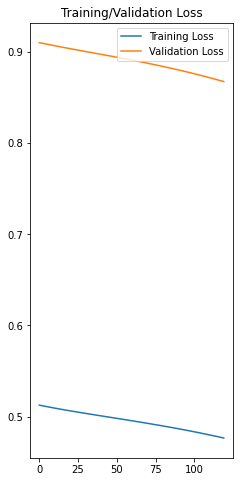

Epoch 1/120
9/9 [==============================] - 2s 17ms/step - loss: 0.5956 - mae: 0.5826 - rmse: 0.6148 - val_loss: 0.8213 - val_mae: 0.8195 - val_rmse: 0.8213
Epoch 2/120
9/9 [==============================] - 0s 13ms/step - loss: 0.5939 - mae: 0.5807 - rmse: 0.6131 - val_loss: 0.8188 - val_mae: 0.8169 - val_rmse: 0.8188
Epoch 3/120
9/9 [==============================] - 0s 12ms/step - loss: 0.5919 - mae: 0.5785 - rmse: 0.6111 - val_loss: 0.8159 - val_mae: 0.8140 - val_rmse: 0.8159
Epoch 4/120
9/9 [==============================] - 0s 12ms/step - loss: 0.5900 - mae: 0.5763 - rmse: 0.6090 - val_loss: 0.8129 - val_mae: 0.8109 - val_rmse: 0.8129
Epoch 5/120
9/9 [==============================] - 0s 13ms/step - loss: 0.5881 - mae: 0.5741 - rmse: 0.6070 - val_loss: 0.8100 - val_mae: 0.8079 - val_rmse: 0.8100
Epoch 6/120
9/9 [==============================] - 0s 12ms/step - loss: 0.5862 - mae: 0.5719 - rmse: 0.6050 - val_loss: 0.8072 - val_mae: 0.8049 - val_rmse: 0.8072
Epoch 7/120
9/9 

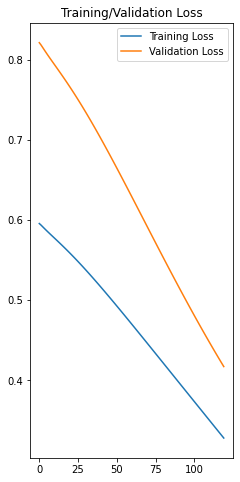

Epoch 1/120
13/13 [==============================] - 0s 14ms/step - loss: 0.3246 - mae: 0.2812 - rmse: 0.3336 - val_loss: 0.9033 - val_mae: 0.8952 - val_rmse: 0.9350
Epoch 2/120
13/13 [==============================] - 0s 13ms/step - loss: 0.3214 - mae: 0.2781 - rmse: 0.3305 - val_loss: 0.9026 - val_mae: 0.8945 - val_rmse: 0.9344
Epoch 3/120
13/13 [==============================] - 0s 12ms/step - loss: 0.3185 - mae: 0.2753 - rmse: 0.3276 - val_loss: 0.9018 - val_mae: 0.8936 - val_rmse: 0.9337
Epoch 4/120
13/13 [==============================] - 0s 12ms/step - loss: 0.3156 - mae: 0.2725 - rmse: 0.3248 - val_loss: 0.9009 - val_mae: 0.8927 - val_rmse: 0.9329
Epoch 5/120
13/13 [==============================] - 0s 13ms/step - loss: 0.3127 - mae: 0.2698 - rmse: 0.3220 - val_loss: 0.9000 - val_mae: 0.8917 - val_rmse: 0.9322
Epoch 6/120
13/13 [==============================] - 0s 13ms/step - loss: 0.3099 - mae: 0.2671 - rmse: 0.3192 - val_loss: 0.8991 - val_mae: 0.8908 - val_rmse: 0.9315
Epoc

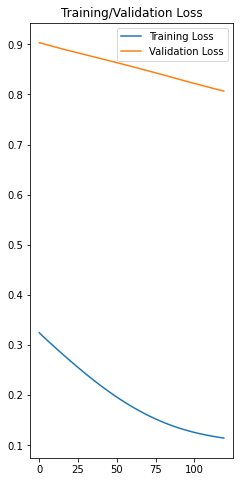

[array([[10597.375 , 10484.459 , 11005.942 , 10145.67  , 11743.245 ,
        10194.983 , 11939.111 , 11586.109 , 11534.646 , 11050.293 ,
        10538.292 , 11363.879 , 10305.103 , 10715.764 , 11576.6875,
        10792.727 , 11086.693 , 10983.238 , 11041.787 , 10917.87  ,
        10701.975 , 10773.388 , 11070.663 , 10889.844 , 10222.45  ,
        10259.643 , 11426.683 , 11052.051 ,  9796.874 , 10809.279 ,
        10947.765 , 11489.894 , 10552.2   , 11244.451 , 11382.421 ,
        10970.008 , 10953.059 , 11187.725 , 10473.673 , 12030.894 ,
        10672.704 , 11372.228 , 10003.797 , 10913.02  , 11242.855 ,
        11492.74  , 10295.768 , 10548.823 , 10374.3545, 10933.572 ,
        10695.995 , 11383.322 , 11274.762 , 11287.402 , 11146.923 ,
        11293.494 , 11189.872 , 10510.953 , 10718.475 , 11666.192 ,
        11108.109 , 10846.365 , 11290.042 , 10734.4   , 10321.873 ,
        11198.448 , 10477.851 , 11217.308 , 11133.492 , 11032.954 ,
        11093.206 , 11494.621 , 11397.82  , 114

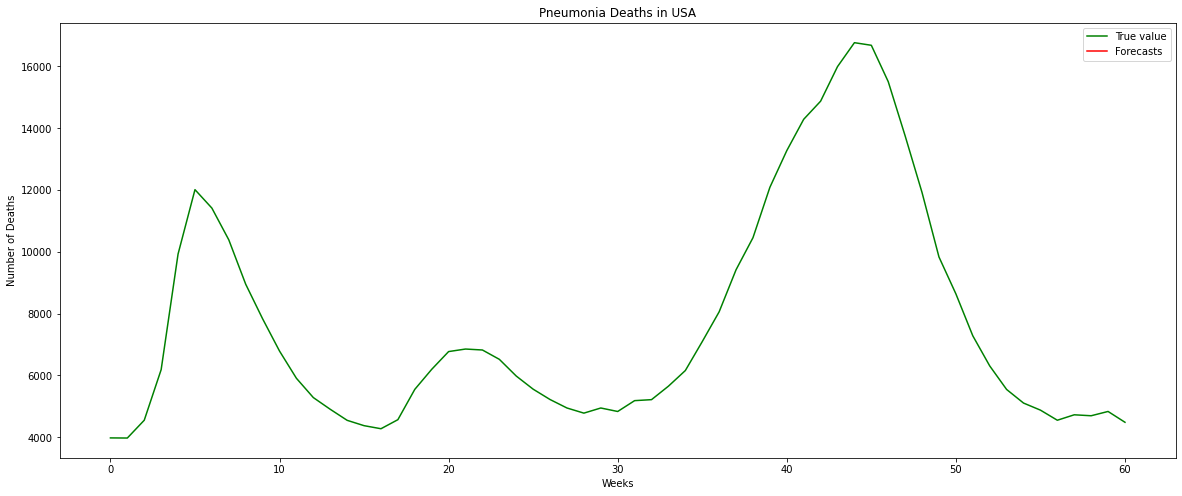

In [20]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  learning_rate = tunning_dict[t]['learning_rate']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print('Previsões:')
  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [21]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [22]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.11300583496689798, 0.11119590823849042, 0.11300583496689798, 0.27555125471204517, 0.2739657207516332, 0.27555125471204517] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.1677936805287997, 0.15639567290743192, 0.1715131146957477, 0.505304796360433, 0.49649222417424116, 0.5024665905162692] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.48382799282670025, 0.46096543644865356, 0.4862325894335906, 0.8454765172799429, 0.8412768336137136, 0.8547987343867619] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.09136769941283597, 0.08958550240430567, 0.09136769941283597, 0.210401178477332, 0.20864949470592867, 0.210401178477332] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.10915866186497386, 0.10158918867646544, 0.11103838293088807, 0.40783282475614985, 0.4008183625837167, 0.40783282475

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.113006,0.111196,0.113006,0.275551,0.273966,0.275551
2,0.167794,0.156396,0.171513,0.505305,0.496492,0.502467
3,0.483828,0.460965,0.486233,0.845477,0.841277,0.854799
4,0.091368,0.089586,0.091368,0.210401,0.208649,0.210401
5,0.109159,0.101589,0.111038,0.407833,0.400818,0.407833
6,0.412543,0.382249,0.420210,0.790084,0.782645,0.801555
7,0.099023,0.096080,0.099023,0.209202,0.206190,0.209202
8,0.094518,0.086584,0.095226,0.334615,0.324555,0.334615
9,0.385115,0.357155,0.393135,0.790497,0.779071,0.803474
